<a href="https://colab.research.google.com/github/JinwangMok/UNI_BigData/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅데이터 학기말 프로젝트 보고서


## 목차

> 서론
>
> 본론
>> 1. 데이터 전처리
>>
>> 2. 데이터 분석 및 시각화
>>
>> 3. 기계 학습 모델 정의 및 활용
>
> 결론

## 서론

본 보고서의 주제는 `상권`으로 의뢰인이 어떠한 상권에 대한 분석을 거액에 요청했다고 가정하고 진행합니다.

> ```
> 서울에 사는 평범한 50대 직장인 나창업씨는 코로나가 끝나감에 따라 다니던 회사를 그만두고 오랜 꿈이었던 요식업에 뛰어들고자 한다.
> 그는 양식음식점을 개점하고자 하며 20대와 30대 연령층의 유동량이 많은 상권을 요구한다.
> 이에 20대와 30대 연령층의 유동량이 많은 2개의 상권에 대해 비교 및 분석하고 보고자하고자 한다.
> ```

본 보고서에서 사용할 데이터는 다음과 같습니다.

>- [서울시 우리마을가게 상권분석서비스(상권-추정매출)](https://data.seoul.go.kr/dataList/OA-15572/S/1/datasetView.do)
>
>- [서울시 우리마을가게 상권분석서비스(상권-생활인구)](https://data.seoul.go.kr/dataList/OA-15568/S/1/datasetView.do)
>

본 보고서의 목표는 서울의 양식음식점 개점을 위해 `양식음식점의 매출과 연령대별 생활인구 수가 서로 연관성이 있는지 분석하고 그에 따라 시각화`를 진행하는 것입니다. 또한, 기계학습을 통해 `특정 지역의 연령대별 생활인구 수를 입력으로 넣으면 예상 매출을 출력하는 회귀 모델`을 만들고자 합니다.

이를 위해 먼저 상권-추정매출 데이터를 활용해 양식음식점의 상권별 양식음식점 점포당 매출액을 계산합니다. 이후 점포당 매출액 상위 10개 상권에 대해 상권-생활인구 데이터를 활용해 연령대별 생활 인구수를 계산합니다. 이를 통해 어떤 연령대가 가장 많은지 시각화하여 분석해봅니다. 그리고 전체 상권의 양식음식점 점포당 매출액과 연령대별 생활인구 수를 활용하여 회귀 모델을 학습시키고 평가합니다.

## 본론



### 1. 데이터 전처리

먼저 필요한 라이브러리와 모듈을 불러오고, 구글 드라이브를 마운트하는 등 데이터 분석 및 시각화에 필요한 작업을 진행해줍니다.

#### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pathlib
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### 한글 폰트 설치 및 적용

> 아래의 셀을 실행하여 폰트 설치 후 런타임 다시 시작

In [ ]:
# Install font for korean lang
# You must Restart Kernel after run this cell
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
# Set default style for plt and set font
plt.style.use('seaborn-white')

plt.rc('font', family='NanumBarunGothic')

#### Google Drive 마운트

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### 고정 변수 선언

In [5]:
PATH = "/content/gdrive/MyDrive/BU/3-2/빅데이터/project/"
SERVICE_KEY = "6c56535547776c7336316c6c6f7142"

#### 데이터 불러오기

> `sales_df` : 서울시 상권 매출 데이터 원본
>
> `population_df` : 서울시 상권 생활인구 데이터 원본

In [6]:
_path = list(pathlib.Path(PATH+'상권매출').rglob('*.csv'))
sales_df = pd.read_csv(_path[0], encoding='cp949')

for p in tqdm(_path[1:], desc="csv파일을 읽어오는 중입니다..."):
    sales_df = pd.concat([sales_df, pd.read_csv(p, encoding='cp949')])

sales_df = sales_df.sort_values(by=['기준_년_코드', '기준_분기_코드', '상권_코드'])
sales_df = sales_df.reset_index(drop=True)

csv파일을 읽어오는 중입니다...: 100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


In [8]:
population_df = pd.read_csv(PATH+'서울시 우리마을가게 상권분석서비스(상권-생활인구).csv', encoding='cp949')

#### 유효 데이터 프레임 변환 

In [10]:
# 유효 column 검색 후 대치
target_columns = ['기준_년_코드', '기준_분기_코드', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '분기당_매출_금액', '점포수']
sales_df = sales_df[target_columns]
# 양식 음식점 조건 검색
sales_df = sales_df[sales_df['서비스_업종_코드_명']=='양식음식점']
# 인덱스 초기화
sales_df = sales_df.reset_index(drop=True)
sales_df.head(2)

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,서비스_업종_코드_명,분기당_매출_금액,점포수
0,2017,1,1001491,이태원 관광특구,양식음식점,25115810986,235
1,2017,1,1001492,명동 남대문 북창동 다동 무교동 관광특구,양식음식점,11155237962,116


In [11]:
# 유효 column 검색 후 대치
target_columns = ['기준 년코드', '기준_분기_코드', '상권_코드', '상권_코드_명', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '총_생활인구_수']
population_df = population_df[target_columns]
# column 이름 정규화
population_df.rename(columns={'기준 년코드':'기준_년_코드'}, inplace=True)
# 순서 정렬 및 인덱스 초기화
population_df = population_df.sort_values(by=['기준_년_코드', '기준_분기_코드'])
population_df = population_df.reset_index(drop=True)
population_df.head(2)

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
0,2017,1,1001496,강남 마이스 관광특구,7531,29457,31796,21207,12456,13711,116156
1,2017,1,1001495,잠실 관광특구,317790,629601,686191,484278,437608,633648,3189116


#### 결측치 처리 

In [12]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11228 entries, 0 to 11227
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   기준_년_코드      11228 non-null  int64 
 1   기준_분기_코드     11228 non-null  int64 
 2   상권_코드        11228 non-null  int64 
 3   상권_코드_명      11228 non-null  object
 4   서비스_업종_코드_명  11228 non-null  object
 5   분기당_매출_금액    11228 non-null  int64 
 6   점포수          11228 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 614.2+ KB


In [13]:
sales_df.isnull().sum()

기준_년_코드        0
기준_분기_코드       0
상권_코드          0
상권_코드_명        0
서비스_업종_코드_명    0
분기당_매출_금액      0
점포수            0
dtype: int64

In [14]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33367 entries, 0 to 33366
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년_코드           33367 non-null  int64 
 1   기준_분기_코드          33367 non-null  int64 
 2   상권_코드             33367 non-null  int64 
 3   상권_코드_명           33367 non-null  object
 4   연령대_10_생활인구_수     33367 non-null  int64 
 5   연령대_20_생활인구_수     33367 non-null  int64 
 6   연령대_30_생활인구_수     33367 non-null  int64 
 7   연령대_40_생활인구_수     33367 non-null  int64 
 8   연령대_50_생활인구_수     33367 non-null  int64 
 9   연령대_60_이상_생활인구_수  33367 non-null  int64 
 10  총_생활인구_수          33367 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.8+ MB


In [15]:
population_df.isnull().sum()

기준_년_코드             0
기준_분기_코드            0
상권_코드               0
상권_코드_명             0
연령대_10_생활인구_수       0
연령대_20_생활인구_수       0
연령대_30_생활인구_수       0
연령대_40_생활인구_수       0
연령대_50_생활인구_수       0
연령대_60_이상_생활인구_수    0
총_생활인구_수            0
dtype: int64

> 보시다시피 결측치가 없으므로 데이터 전처리를 마칩니다.

---

### 2. 데이터 분석 및 시각화

본 보고서에서 사용되는 데이터는 각 행(row)이 연도-분기-상권별로 구분된 데이터입니다. 즉, 동일한 상권이라도 2017년 1분기, 2017년 2분기, ... 로 여러개의 데이터가 존재합니다.

#### 1) 상권-추정매출 데이터(`sales_df`)를 활용해 양식음식점의 상권별 양식음식점 점포당 매출액을 계산

> 먼저 상권별로 점포당 매출액을 계산합니다.
>
> 각 데이터가 분기별로 기록된 데이터이므로 각 상권마다 분기별로 점포당 매출액의 평균 값을 구한 뒤 그 값의 평균을 해당 상권의 점포당 매출액으로 계산합니다.

In [16]:
print(f"총 상권의 개수 : {len(sales_df['상권_코드_명'].unique())}개")

총 상권의 개수 : 688개


In [17]:
mean_sales_each_store = {}
for area in list(sales_df['상권_코드_명'].unique()):
    temp = sales_df[(sales_df['상권_코드_명']==area)&(sales_df['점포수'] != 0)]
    # 양식음식점이 없거나 점포수가 없는 예외 상황에 대한 처리
    if len(temp) == 0:
        continue
    sales_each_store = temp['분기당_매출_금액'] / temp['점포수']
    sales_each_store.map(lambda x : x if x != np.inf else 0)
    mean_sales_each_store[area] = sales_each_store.sum() / len(sales_each_store)

In [18]:
print(f"강남역의 점포당 평균 매출액 : {mean_sales_each_store['강남역']}")

강남역의 점포당 평균 매출액 : 57242361.91459261


> 강남역의 경우 분기당 각 점포마다 평균 약 57,242,361원의 매출을 기록했습니다.
>
> 이 중 가장 높은 점포당 평균 매출액을 기록한 10개 상권을 선정하고 매출액을 시각화해보겠습니다.

In [19]:
mean_sales_each_store_best10 = pd.Series(mean_sales_each_store).sort_values(ascending=False)[:10]
mean_sales_each_store_best10 = mean_sales_each_store_best10.sort_values(ascending=True)
mean_sales_each_store_best10

코엑스                 1.088859e+08
삼성중앙역 5번            1.141659e+08
강남 마이스 관광특구         1.162352e+08
로데오거리상점가            1.177312e+08
영등포역(영등포)           1.177987e+08
제일시장                1.309277e+08
평화시장(통일상가, 동화상가)    1.409360e+08
만양로상점가              1.432817e+08
고속터미널(고속터미널역)       1.452045e+08
월드컵경기장역(월드컵경기장)     2.885029e+08
dtype: float64

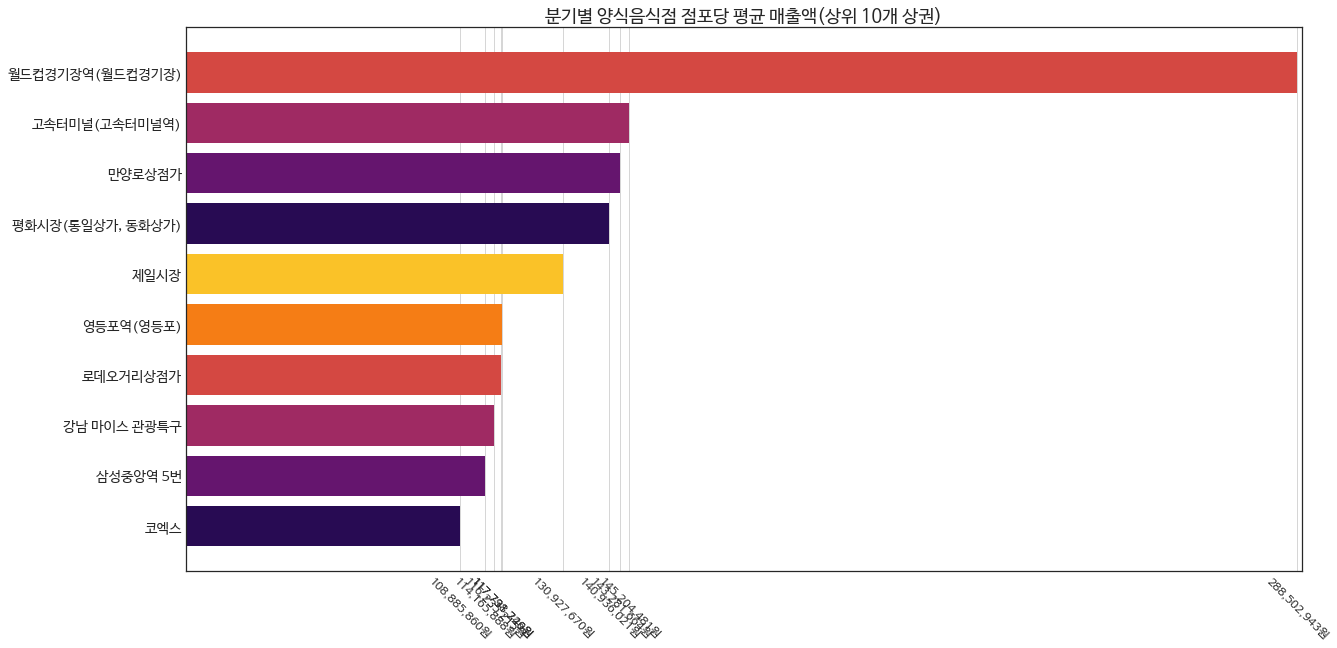

In [20]:
plt.figure(figsize=(20, 10))
plt.barh(mean_sales_each_store_best10.index, mean_sales_each_store_best10.values, color=sns.color_palette('inferno'))
plt.xticks(mean_sales_each_store_best10.values, ["{x:,.0f}원".format(x=x) for x in mean_sales_each_store_best10.values], rotation=315, size=12)
plt.xlim(50000000, mean_sales_each_store_best10.max()+1000000)
plt.yticks(size=14)
plt.title("분기별 양식음식점 점포당 평균 매출액(상위 10개 상권)", size=18)
plt.grid(axis='x')
plt.show()

> 추가적으로 위 10개 상권의 평균 점포의 개수를 살펴보도록 하겠습니다.

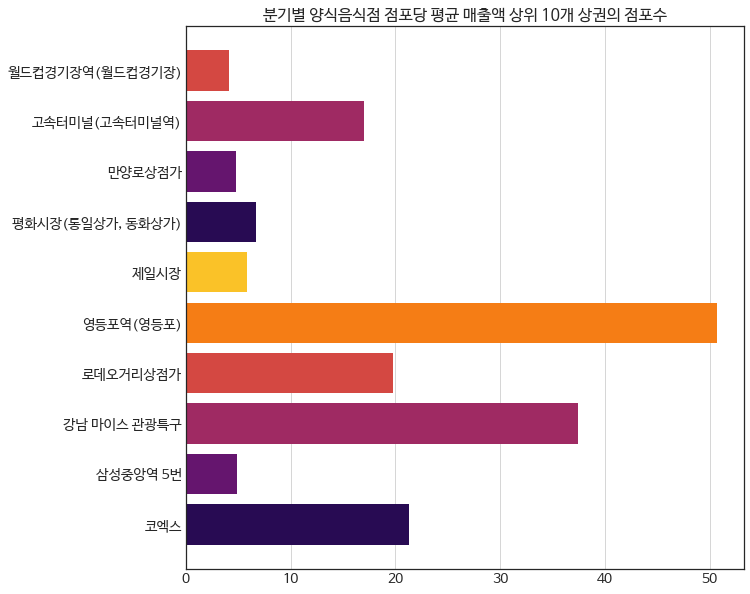

In [21]:
mean_sales_each_store_best10_store_num = {}
for area in mean_sales_each_store_best10.keys():
    mean_sales_each_store_best10_store_num[area] = sales_df[sales_df['상권_코드_명']==area]['점포수'].mean()

plt.figure(figsize=(10, 10))
plt.barh(list(mean_sales_each_store_best10_store_num.keys()), list(mean_sales_each_store_best10_store_num.values()), color=sns.color_palette('inferno'))
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(axis='x')
plt.title("분기별 양식음식점 점포당 평균 매출액 상위 10개 상권의 점포수", size=16)
plt.show()

#### 2) 점포당 매출액 상위 10개 상권에 대해 상권-생활인구 데이터를 활용해 연령대별 생활 인구수 계산

`sales_df`와 `population_df`는 동일한 `상권_코드` 값을 가지고 있습니다. 또한 앞선 `sales_df`와 마찬가지로 `population_df`도 각 분기당 상권별 데이터로 구성되어있습니다. 이를 활용해 앞서 구한 상위 10개 상권에 대해 분기별 평균 각 연령대의 생활인구 수를 계산합니다.

In [22]:
# 상권명과 상권 코드를 매핑한 딕셔너리 생성
area_code_dict = {}
for area in mean_sales_each_store_best10.keys():
    area_code_dict[area] = sales_df[sales_df['상권_코드_명']==area]['상권_코드'].unique()[0]

In [23]:
age_per_best10_area = {}
for area, code in area_code_dict.items():
    temp = population_df[population_df['상권_코드']==code]
    age_per_best10_area[area] = {
        '10' : temp['연령대_10_생활인구_수'].mean(),
        '20' : temp['연령대_20_생활인구_수'].mean(),
        '30' : temp['연령대_30_생활인구_수'].mean(),
        '40' : temp['연령대_40_생활인구_수'].mean(),
        '50' : temp['연령대_50_생활인구_수'].mean(),
        '60이상' : temp['연령대_60_이상_생활인구_수'].mean()
    }

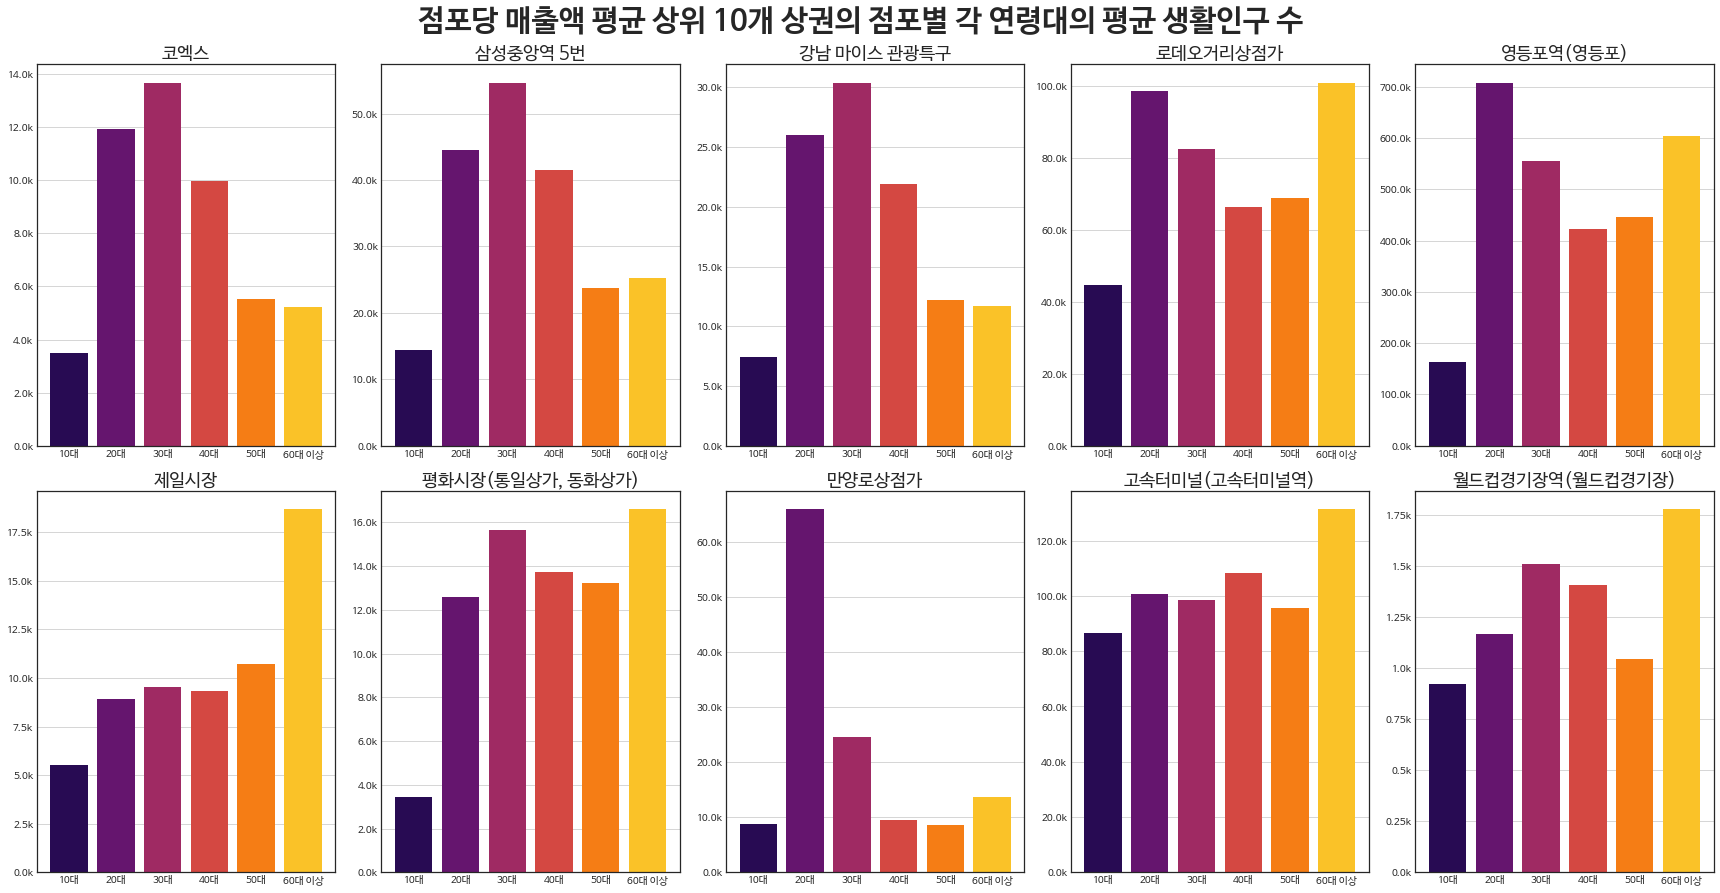

In [24]:
X = np.arange(6)
fig, axs = plt.subplots(2, 5, figsize=(24, 12), tight_layout=True)
fig.suptitle("점포당 매출액 평균 상위 10개 상권의 점포별 각 연령대의 평균 생활인구 수", fontsize=30, fontweight='bold', y=1.03)
for idx, area in enumerate(age_per_best10_area.keys()):
    axs[idx//5, idx%5].bar(['10대', '20대', '30대', '40대', '50대', '60대 이상'], list(age_per_best10_area[area].values()), color=sns.color_palette('inferno'))
    current_values = axs[idx//5, idx%5].get_yticks()
    axs[idx//5, idx%5].set_yticklabels([f'{x/1000}k' for x in current_values])
    axs[idx//5, idx%5].grid(axis='y')
    axs[idx//5, idx%5].title.set_text(f"{area}")
    axs[idx//5, idx%5].title.set_size(18)
plt.show()

> 10개의 상권 중 5개 상권이 60대 이상 생활인구가 가장 많은 결과를 보여줬습니다.
>
> 하지만, 비율 상 가장 많은 것이고 10개 상권의 연령별 총 생활인구 수 합계는 아래와 같은 결과를 보여줍니다.

In [25]:
population_per_age = {}
for age in ['10', '20', '30', '40', '50', '60이상']:
    population_per_age[age] = 0
    for area in age_per_best10_area.keys():
        population_per_age[age] += age_per_best10_area[area][age]

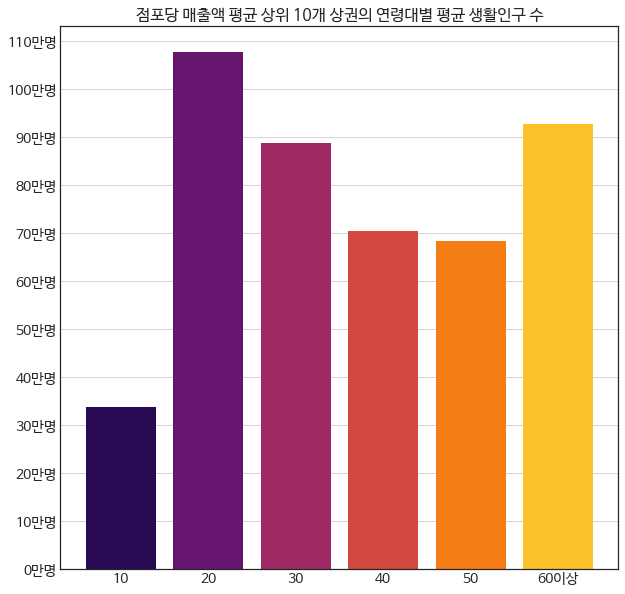

In [26]:
plt.figure(figsize=(10, 10))
plt.bar(list(population_per_age.keys()), list(population_per_age.values()), color=sns.color_palette('inferno'))
plt.xticks(size=14)
plt.yticks(range(0, 1200000, 100000), [f"{i//10000}만명"for i in range(0, 1200000, 100000)], size=14)
plt.grid(axis='y')
plt.title("점포당 매출액 평균 상위 10개 상권의 연령대별 평균 생활인구 수", size=16)
plt.show()

> 이처럼 양식 음식점의 매출에 큰 영향을 미치는 연령대는 `20대 > 60대 이상 > 30대 > 40대 > 50대 > 10대` 순서로 확인할 수 있습니다.

### 3. 기계 학습 모델 정의 및 활용 

마지막으로 연령대별 생활 인구 수를 통해 점포당 매출액을 계산하는 다중 회귀 모델을 정의하고 모델을 평가해보도록 하겠습니다.

먼저, 모델의 학습 데이터를 생성하도록 하겠습니다.

이를 위해 양식 음식점의 분기별 각 상권의 점포당 매출액과 해당 상권의 분기별 각 연령대의 생활 인구 수를 구해 보기 쉽게 하나의 데이터 프레임으로 나타내겠습니다.

> 우선 상권 매출 데이터에서 양식 음식점에 해당하는 행과 점포수가 0이 아닌 행만 검색해 `data_for_model` 데이터 프레임으로 저장합니다.

In [27]:
data = sales_df[(sales_df['서비스_업종_코드_명']=='양식음식점')&(sales_df['점포수'] != 0)]
data.head(2)

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,서비스_업종_코드_명,분기당_매출_금액,점포수
0,2017,1,1001491,이태원 관광특구,양식음식점,25115810986,235
1,2017,1,1001492,명동 남대문 북창동 다동 무교동 관광특구,양식음식점,11155237962,116


> 그 중 상권 코드 명이 강남역인 3개 행만 조회하면 아래와 같습니다.

In [28]:
data[data['상권_코드_명']=='강남역'][:3]

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,서비스_업종_코드_명,분기당_매출_금액,점포수
539,2017,1,2120189,강남역,양식음식점,19914915375,249
1205,2017,2,2120189,강남역,양식음식점,18430223064,259
1861,2017,3,2120189,강남역,양식음식점,20035229500,257


> 동일하게 상권 생활 인구 수 데이터에서도 상권 코드 명이 강남역인 3개 행만 조회하면 아래와 같습니다.

In [29]:
population_df[population_df['상권_코드_명']=='강남역'][:3]

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
390,2017,1,2120189,강남역,695791,2901844,1864003,1152494,694583,794811,8103525
2058,2017,2,2120189,강남역,695555,2663640,1828312,1143171,678656,761678,7771013
3726,2017,3,2120189,강남역,796984,2822234,1822246,1188174,694558,747313,8071510


> 이처럼 2017년 1-3분기의 강남역의 매출 데이터와 생활 인구 수 데이터를 합치기 위해 아래와 같이 pd.merge() 메소드를 사용할 수 있습니다.

In [142]:
data = pd.merge(data, population_df, how='left', left_on=['기준_년_코드', '기준_분기_코드', '상권_코드'], right_on=['기준_년_코드', '기준_분기_코드', '상권_코드'])
data[data['상권_코드_명_x']=='강남역'][:3]

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명_x,서비스_업종_코드_명,분기당_매출_금액,점포수,상권_코드_명_y,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
538,2017,1,2120189,강남역,양식음식점,19914915375,249,강남역,695791,2901844,1864003,1152494,694583,794811,8103525
1203,2017,2,2120189,강남역,양식음식점,18430223064,259,강남역,695555,2663640,1828312,1143171,678656,761678,7771013
1857,2017,3,2120189,강남역,양식음식점,20035229500,257,강남역,796984,2822234,1822246,1188174,694558,747313,8071510


> 이 때, 상권 코드 명이 두 데이터 프레임에 모두 존재하므로 x와 y로 나뉜 것을 볼 수 있습니다.
>
> 하지만, 아래와 같이 두 데이터 프레임의 상권 코드 명이 정확하게 일치하지 않고 공백 문자나 특수문자 등의 차이를 보이는 것을 볼 수 있습니다.

In [143]:
i = 0
for x, y in zip(data['상권_코드_명_x'], data['상권_코드_명_y']):
    if x != y:
        print(x)
        print(y)
        print()
        i += 1
    if i == 5:
        break

종로·청계 관광특구
종로?청계 관광특구

천왕역 3번(오류2동주민센터, 서울오류남초등학교)
천왕역 3번(오류2동주민센터 서울오류남초등학교)

신림역 5번(신림동주민센터, 신림동별빛거리)
신림역 5번(신림동주민센터 신림동별빛거리)

숙대입구역(남영역, 남영동)
숙대입구역(남영역 남영동)

신촌역(신촌역, 신촌로터리)
신촌역(신촌역 신촌로터리)



> 또한, 상권 코드 명이 중요한 데이터가 아니므로 두 열 모두 모델 학습 데이터에서 제외합니다.
>
> 그리고 실제 모델의 학습 과정에서 기준\_년\_코드, 기준\_분기\_코드, 상권\_코드, 서비스\_업종\_코드\_명은 사용되지 않으므로 이 또한 데이터에서 제외합니다.
>
> 결국 사용하는 열은 [분기당_매출_금액,	점포수,	연령대_10_생활인구_수,	연령대_20_생활인구_수,	연령대_30_생활인구_수,	연령대_40_생활인구_수,	연령대_50_생활인구_수,	연령대_60_이상_생활인구_수,	총_생활인구_수] 입니다.
>
> 이에 따라 데이터를 가공해줍니다.

In [144]:
data_for_model = data[['분기당_매출_금액', '점포수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '총_생활인구_수']]
data_for_model.head(2)

,분기당_매출_금액,점포수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
0,25115810986,235,131076,701136,491721,274367,238668,388070,2225040
1,11155237962,116,227693,1244047,1559865,1220249,855999,1042908,6150764


> 이렇게 구한 데이터들의 상관계수(`correlation`)를 구하면 어떤 열이 예측에 깊게 관여하는지 미리 파악해볼 수 있습니다.
>
> 따라서 `data_for_model` 데이터 프레임의 상관계수를 구하고 시각화해보겠습니다.
>
> 먼저 피어슨 상관계수를 구하면 다음과 같습니다.


In [145]:
plot_corr = data_for_model.corr(method="pearson")
plot_corr

,분기당_매출_금액,점포수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
분기당_매출_금액,1.000000,0.878497,0.145521,0.411350,0.396120,0.323899,0.222370,0.154924,0.323275
점포수,0.878497,1.000000,0.217427,0.522935,0.471407,0.387306,0.263569,0.191792,0.400936
연령대_10_생활인구_수,0.145521,0.217427,1.000000,0.660419,0.685891,0.779498,0.819577,0.831673,0.842657
연령대_20_생활인구_수,0.411350,0.522935,0.660419,1.000000,0.848947,0.769727,0.714510,0.663502,0.877421
연령대_30_생활인구_수,0.396120,0.471407,0.685891,0.848947,1.000000,0.961529,0.879201,0.801512,0.950427
연령대_40_생활인구_수,0.323899,0.387306,0.779498,0.769727,0.961529,1.000000,0.952568,0.880294,0.964009
연령대_50_생활인구_수,0.222370,0.263569,0.819577,0.714510,0.879201,0.952568,1.000000,0.966583,0.952740
연령대_60_이상_생활인구_수,0.154924,0.191792,0.831673,0.663502,0.801512,0.880294,0.966583,1.000000,0.915055
총_생활인구_수,0.323275,0.400936,0.842657,0.877421,0.950427,0.964009,0.952740,0.915055,1.000000


> 이를 시각화하면 아래와 같습니다.

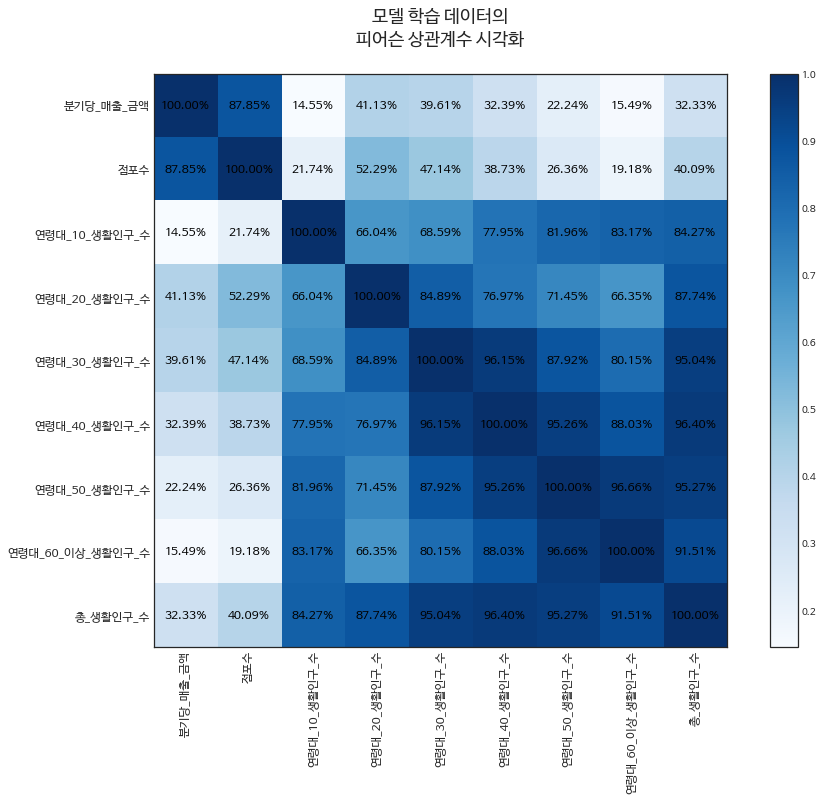

In [148]:
fig, ax = plt.subplots()
im = ax.imshow(plot_corr, cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(plot_corr.columns)))
ax.set_yticks(np.arange(len(plot_corr.index)))

ax.set_xticklabels(plot_corr.columns)
ax.set_yticklabels(plot_corr.columns)

for x in range(len(plot_corr.columns)):
    for y in range(len(plot_corr.index)):
        ax.text(y, x, "%.2lf%%"%(plot_corr.iloc[y, x]*100), ha='center', va='center', size=12, color='K')
fig.set_size_inches(12.5, 8.5)
fig.tight_layout()  
plt.xticks(rotation=90, size=12) 
plt.yticks(size=12) 
plt.title("모델 학습 데이터의\n피어슨 상관계수 시각화\n", size=18)
plt.show()

> 위의 상관계수에서 확인할 수 있듯이 예측하고자 하는 `분기당 매출 금액`과 가장 높은 상관관계를 보이는 값은 `점포수`입니다.
>
> 이는 현실에서도 동일 상권 내에 점포수가 많으면 매출이 적어질 수 있음을 고려하면 타당한 결과라고 볼 수 있습니다.
>
> 연령대 중에서는 20대, 30대 생활인구 수가 40% 전후로 상관관계를 가지는 것으로 미루어보아 20-30대 연령대의 생활인구 수도 매출에 영향을 줄 수 있다고 판단할 수 있습니다.

> 본격적으로 모델을 학습을 위해 데이터를 분할하겠습니다.
>
> 완성된 데이터 프레임에서 구하고자하는 예측 값`y`는 분기당 매출 금액이며 나머지는 `X` 값입니다.
>
> 이제 sklearn의 `train_test_split` 메소드를 통해 데이터를 학습용과 검증용으로 나눠주겠습니다.

In [33]:
X = data_for_model[['점포수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '총_생활인구_수']]
y = data_for_model['분기당_매출_금액']

X_train, X_test, y_train, y_test = train_test_split(X, y)

> X_train과 y_train을 확인해보면 다음과 같습니다.

In [34]:
X_train[:1]

,점포수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
2209,3,16934,14667,19623,19123,21809,36197,128352


In [35]:
y_train[:1]

2209    85138361
Name: 분기당_매출_금액, dtype: int64

> 다음으로 (다중)선형 회귀 모델인 sklearn의 LinearRgression()을 생성합니다.
>
>> 다중 선형 회귀는 다음과 같은 방정식으로 나타낼 수 있습니다.
>>
>> $$ y = b + m_1 x_1 + m_2 x_2 + ... + m_n x_n $$
>>
>> 이때, $n$은 차수(`rank`)를 의미합니다.


In [36]:
model = LinearRegression()

> 이제 X_train과 y_train으로 학습을 진행합니다.

In [37]:
model.fit(X_train, y_train)

LinearRegression()

> 이렇게 학습된 모델은 다음과 같은 속성을 가집니다. 

In [38]:
print(f"모델의 차수 : {model.rank_}")
print(f"모델의 회귀계수(m) : {model.coef_}")
print(f"모델의 상수(b) : {model.intercept_}")

모델의 차수 : 8
모델의 회귀계수(m) : [52052679.22093387 -4176984.40615664 -4177087.5145863  -4174376.93704696
 -4179990.26646671 -4170365.61989923 -4177321.56682028  4176088.64124673]
모델의 상수(b) : -94374684.34975612


> 추후 시각화를 위해 위 모델로 `X_test`에 대해 `predict()` 메소드로 예측을 진행하고 `y_predict`로 저장합니다.

In [39]:
y_predict = model.predict(X_test)

> 실제 값과 예측된 값을 통해 산포도 그래프로 시각화해보겠습니다.
>
> 만약 실제 값과 예측된 값이 비슷하다면 기울기가 1인 직선과 같이 그려질 것입니다.

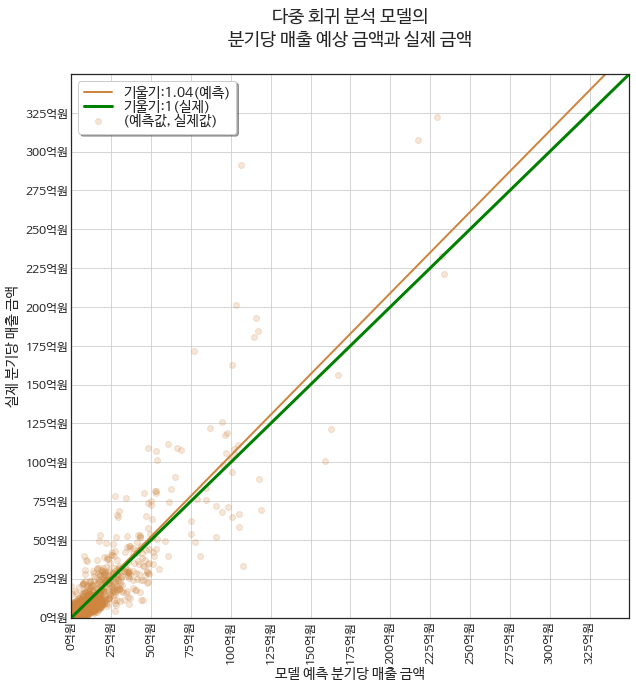

In [149]:
max_lim, _step = 3.5e10, 2.5e9
plt.figure(figsize=(10, 10))
# 결과 산포도 그리기
plt.scatter(y_predict, y_test, color='peru', alpha=0.2, label='(예측값, 실제값)')
# 결과 산포도의 기울기를 구하고 직선 그리기
slope, intercept = np.polyfit(y_predict,y_test,1)
_x = np.arange(0, max_lim+_step, _step)
_y = _x * slope
plt.plot(_x, _y, color='peru', linewidth=2, label='기울기:%.2lf(예측)'%slope)

# 실제 기울기가 1인 직선 그리기
plt.plot(_x, _x, color='green', linewidth=3, label='기울기:1(실제)')
plt.legend(fontsize=14, fancybox=True, shadow=True, frameon=True, facecolor='white', labelspacing=0, loc='upper left')
plt.grid(True)
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.xticks(np.arange(0, max_lim, _step), [f"{int(x//1e8)}억원" for x in np.arange(0, max_lim, _step)], rotation=90, size=12)
plt.yticks(np.arange(0, max_lim, _step), [f"{int(x//1e8)}억원" for x in np.arange(0, max_lim, _step)], size=12)
plt.title('다중 회귀 분석 모델의\n분기당 매출 예상 금액과 실제 금액\n', size=18)
plt.xlabel('모델 예측 분기당 매출 금액', size=14)
plt.ylabel('실제 분기당 매출 금액', size=14)
plt.show()

> 더 많은 값이 분포된 100억원까지만 확대하여 그리면 아래와 같습니다.

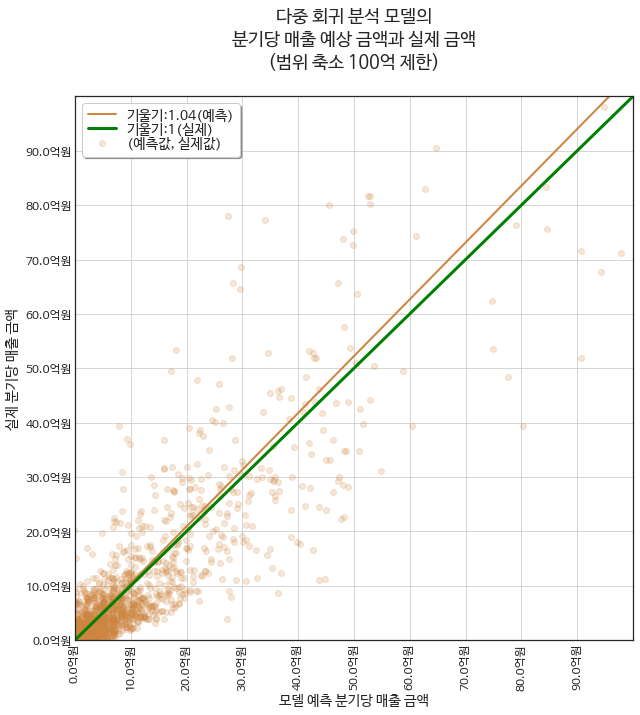

In [150]:
max_lim, _step = 1e10, 1e9
plt.figure(figsize=(10, 10))
# 결과 산포도 그리기
plt.scatter(y_predict, y_test, color='peru', alpha=0.2, label='(예측값, 실제값)')
# 결과 산포도의 기울기를 구하고 직선 그리기
slope, intercept = np.polyfit(y_predict,y_test,1)
_x = np.arange(0, max_lim+_step, _step)
_y = _x * slope
plt.plot(_x, _y, color='peru', linewidth=2, label='기울기:%.2lf(예측)'%slope)

# 실제 기울기가 1인 직선 그리기
plt.plot(_x, _x, color='green', linewidth=3, label='기울기:1(실제)')
plt.legend(fontsize=14, fancybox=True, shadow=True, frameon=True, facecolor='white', labelspacing=0, loc='upper left')
plt.grid(True)
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.xticks(np.arange(0, max_lim, _step), ["%.1lf억원"%(x/1e8) for x in np.arange(0, max_lim, _step)], rotation=90, size=12)
plt.yticks(np.arange(0, max_lim, _step), ["%.1lf억원"%(x/1e8) for x in np.arange(0, max_lim, _step)], size=12)
plt.title('다중 회귀 분석 모델의\n분기당 매출 예상 금액과 실제 금액\n(범위 축소 100억 제한)\n', size=18)
plt.xlabel('모델 예측 분기당 매출 금액', size=14)
plt.ylabel('실제 분기당 매출 금액', size=14)
plt.show()

> 본 모델의 정확도를 `score()` 메소드를 통해 구하면 81.32%의 결과를 확인할 수 있습니다.

In [213]:
print("다중 회귀 모델이 예측한 분기당 매출 금액의 정확도는 %.2lf%% 입니다."%(model.score(X_test, y_test)*100))

다중 회귀 모델이 예측한 분기당 매출 금액의 정확도는 81.32% 입니다.


> 마지막으로 본 모델을 활용해 특정 상권을 선정하고 해당 상권의 점포수와 연령대별 생활인구 수, 총 생활인구 수를 입력으로 전달해 예측한 예상 매출액과 실제 매출액을 비교해보겠습니다.
>
> 먼저 상권 매출과 생활인구 수가 합쳐진 `data` 데이터 프레임에서 임의로 5개를 선정하여 `sample`로 저장합니다.

In [229]:
sample = data.iloc[np.random.randint(0, len(data), 5), :]
sample

,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명_x,서비스_업종_코드_명,분기당_매출_금액,점포수,상권_코드_명_y,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,총_생활인구_수
479,2017,1,2120114,목동신시가지,양식음식점,3194223258,46,목동신시가지,315018,219945,231520,325245,241156,311921,1644805
6811,2019,3,2130106,중랑동부시장,양식음식점,26541747,3,중랑동부시장,66341,71240,82292,85778,97305,146280,549237
4518,2018,3,2130053,백학시장,양식음식점,56681175,6,백학시장,88504,110416,129416,121240,129439,185551,764567
6981,2019,4,2110521,홍제역 4번,양식음식점,27000000,6,홍제역 4번,79969,82865,72880,91361,102237,201513,630825
10910,2021,4,2110783,영등포시장역 1번,양식음식점,15000000,3,영등포시장역 1번,21102,41251,56982,45631,31115,33807,229886


> 이 중에서 예측에 사용될 열은 `'점포수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '총_생활인구_수'`이므로 `features`로 저장해줍니다.

In [230]:
features = ['점포수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '총_생활인구_수']

> 이제 반복문을 사용하여 각 상권의 매출을 예측해봅니다.

In [231]:
sample_x = sample[features].reset_index(drop=True)
sample_y = sample['분기당_매출_금액'].reset_index(drop=True)

result = model.predict(sample_x)
for i in range(5):
    print("{area}상권의 실제 매출액은 {x:,.0f}원이고, 모델이 예측한 매출액은 {y:,.0f}원입니다. 예측 차액은 {z:,.0f}원입니다.".format(
        area= sample.iloc[i]['상권_코드_명_x'], x=sample_y[i], y=result[i], z=result[i]-sample_y[i]
        ), end='\n\n')

목동신시가지상권의 실제 매출액은 3,194,223,258원이고, 모델이 예측한 매출액은 1,921,044,513원입니다. 예측 차액은 -1,273,178,745원입니다.

중랑동부시장상권의 실제 매출액은 26,541,747원이고, 모델이 예측한 매출액은 118,085,959원입니다. 예측 차액은 91,544,212원입니다.

백학시장상권의 실제 매출액은 56,681,175원이고, 모델이 예측한 매출액은 293,047,560원입니다. 예측 차액은 236,366,385원입니다.

홍제역 4번상권의 실제 매출액은 27,000,000원이고, 모델이 예측한 매출액은 168,482,950원입니다. 예측 차액은 141,482,950원입니다.

영등포시장역 1번상권의 실제 매출액은 15,000,000원이고, 모델이 예측한 매출액은 49,215,783원입니다. 예측 차액은 34,215,783원입니다.



> 정확도와는 관계없이 금액의 차이가 매우 많이 나는 것을 볼 수 있습니다.
>
> 이를 해결하려면 딥러닝 모델과 같은 더 나은 모델을 사용하거나 너무 큰 이상치 값을 제외하거나 모델에 안좋은 영향을 주는 관련없는 열들을 제거하는 등의 추가적인 작업이 필요하다고 생각합니다.

## 결론

> 본 프로젝트를 통해 서울 상권 중 양식음식점의 매출 금액과 해당 상권의 연령별 생활인구 수의 상관관계를 분석한 결과 생활인구와는 밀접한 관련이 없어보이며 오히려 동일 상권 내에 양식음식점의 점포수가 더 밀접한 상관관계를 갖는 것을 발견할 수 있었습니다. 
>
> 그리고 다중 선형 회귀 모델을 활용해 점포수, 연령대별 생활인구 수, 총 생활인구 수를 입력으로 분기 단위의 매출 금액을 예측해봤습니다. 그러나 사용한 열들과 매출 금액 간의 상관관계가 적은 점과 딥러닝 모델이 아닌 통계에 기반하는 선형 회귀 모델인 점 등의 한계로 좋은 결과를 내지는 못했습니다.
>
> 차후에는 이러한 데이터 전처리 과정과 분석 및 시각화, 모델 선정 및 모델 학습 과정을 학습하고 연구하여 더 좋은 성능을 낼 수 있는 특징들과 모델을 선정하는 능력을 기르고자 합니다.

#### 느낀점

> 한 학기동안 데이터를 수집하고 전처리하는 과정과 기계학습을 공부하면서 최선을 다해 공부했지만 아직도 미진하고 부족한 부분들이 많다는 것을 다시금 깨닫는 프로젝트였습니다.
>
> 아직도 배울 것이 많이 남아있다는 것에 막막하면서도 한편으로는 새로운 지식을 배울 것이라는 기대에 설레입니다.
>
> 매주 교수님의 피드백을 통해 더 발전할 수 있었고 팀프로젝트를 통해 팀원들과 소통하면서 다양한 시각에서 데이터를 바라볼 수 있어 유익한 시간이었습니다.
>
> 한 학기동안 잘 지도해주셔서 감사드립니다!